In [81]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import time
import geopandas as gdp
from cartoframes.viz import Map, Layer, popup_element
import cartoframes
from dotenv import load_dotenv
from getpass import getpass
import re
import keplergl
import plotly.express as px
import folium
import json
import requests
from folium import Choropleth, Circle, Marker, Icon, Map, TileLayer
from folium.plugins import HeatMap, MarkerCluster
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
client = MongoClient("localhost:27017")

db = client["ironhack"]


In [3]:
db.list_collection_names()

['nyrest', 'Crunchbase', 'restaurants', 'nyneigh']

In [4]:
c = db.get_collection("Crunchbase")

In [5]:
#company_category = set()

In [6]:
#df_tech_general = pd.DataFrame()

In [5]:
#def tech_df_function():

tech_name_regex = {"name":{"$regex":"^(tech|frontend|backend|web develop|ux develop|ui develop|gaming|gamer)", "$options":"i"}}
tech_category_regex ={"category_code":{"$regex":"^(tech|frontend|backend|web develop|ux develop|ui develop|gaming|gamer)", "$options":"i"}}
tech_description_regex = {"description":{"$regex":"^(tech|frontend|backend|web develop|ux develop|ui develop|gaming|gamer)", "$options":"i"}}
tech_tags_regex = {"tag_list":{"$regex":"^(tech|frontend|backend|web develop|ux develop|ui develop|gaming|gamer)", "$options":"i"}}

tech_cat_or_descr_or_tags = {"$or": [tech_name_regex, tech_category_regex, tech_description_regex, tech_tags_regex]}

projection_name_category_tags = {"_id" : 0, 
                                    "name" : 1, 
                                    "category_code": 1, 
                                    "tag_list": 1,
                                    "total_money_raised": 1,
                                    "offices.country_code" : 1, 
                                    "offices.city" : 1, 
                                    "offices.zip_code" : 1, 
                                    "offices.latitude" : 1, 
                                    "offices.longitude" : 1}

tech_companies_list = list(c.find(tech_cat_or_descr_or_tags, projection_name_category_tags).sort("offices.city", 1))
df_tech_general = pd.DataFrame(tech_companies_list)

    #return df_tech_general

In [7]:
#tech_df_function()

In [8]:
df_tech_general.shape

(285, 5)

In [9]:
def clean_monetary_values(dataframe, column):
    
    for index, row in dataframe.iterrows():
        if pd.isnull(row[column]):
            continue
        
        match = re.search('(\d+\.\d+|\d+)([MmKk])', row[column])
        if not match:
            dataframe.at[index, column] = pd.np.nan
            continue
        
        value, letter = match.groups()
        value = float(value)
        if value <= 0:
            dataframe.at[index, column] = pd.np.nan
            continue
        
        if letter.upper() == 'M':
            value *= 1000000
        else:
            value *= 1000
        
        dataframe.at[index, column] = value
    
    return dataframe


In [10]:
clean_monetary_values(df_tech_general, "total_money_raised")

C:\Users\germa\AppData\Local\Temp\ipykernel_7200\4024254625.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  dataframe.at[index, column] = pd.np.nan


,name,category_code,tag_list,total_money_raised,offices
0,Sparter,games_video,"gaming, game, wow, worldofwarcraft, virtualgoods",NaN,"[{'zip_code': None, 'city': None, 'country_cod..."
1,Devunity,web,"techcrunch50, tc50",100000.0,[]
2,TechJuicer,None,None,NaN,[]
3,Lockergnome,None,"tech-news, it-news, blog",NaN,[]
4,Apperceptive,web,design,NaN,[]
...,...,...,...,...,...
280,Pacecode Technologies,consulting,"website-development-in-india, website-design-i...",NaN,"[{'zip_code': '600020', 'city': 'chennai', 'co..."
281,MakeMyLink,advertising,"technology, web-design, seo, software-blog, guide",NaN,"[{'zip_code': '110075', 'city': 'new delhi', '..."
282,Tech Support 4 NYC,consulting,"computer-consulting, tech-support, new-york-city",NaN,"[{'zip_code': '10018', 'city': 'new york', 'co..."
283,GoPlanit,web,"techcrunch50, tc50, travel, trip-planner, mobi...",500000.0,"[{'zip_code': '94111', 'city': 'san francisco'..."


In [11]:
#def design_df_function():
   
design_name_regex = {"name":{"$regex":"design", "$options":"i"}}
design_category_regex ={"category_code":{"$regex":"design", "$options":"i"}}
design_description_regex = {"description":{"$regex":"design", "$options":"i"}}
design_tags_regex = {"tag_list":{"$regex":"design", "$options":"i"}}

design_cat_or_descr_or_tags = {"$or": [design_name_regex, design_category_regex, design_description_regex, design_tags_regex]}

design_projection_name_category_tags = {"_id" : 0, 
                                            "name" : 1, 
                                            "category_code": 1, 
                                            "tag_list": 1,
                                            "offices.country_code" : 1, 
                                            "offices.city" : 1, 
                                            "offices.zip_code" : 1, 
                                            "offices.latitude" : 1, 
                                            "offices.longitude" : 1}

design_companies_list = list(c.find(design_cat_or_descr_or_tags, design_projection_name_category_tags).sort("offices.city", 1))
df_design = pd.DataFrame(design_companies_list)
#    return df_design

In [12]:
#design_df_function()

In [13]:
def split_dic_df_columns(dataframe, dataframe_column):
    
    """This funcion takes 2 parameters:
    1. name of given dataframe
    2. name of column that contains dictionaries as values

    It will iterate over the rows, then the specified column, checking for missing values.
    If the values is not missing, then iterate over each 
    dictionary item, and chek if the column to be created already exists.
    Then initialize the column values to zero, and then update values
    with the ones corresponding in the dictionary.
    return the original dataframe updated with a new column per each 
    key in the dictionaries, and its values.
    """
    for i, row in dataframe.iterrows():
        for j in row[dataframe_column]:
            if not pd.isnull(j):
                for x, y in j.items():
                    if x not in dataframe.columns:
                        dataframe[str(x)] = np.nan
                    dataframe.at[i, x] = y
    return dataframe



In [14]:
split_dic_df_columns(df_design, "offices")

,name,category_code,tag_list,offices,zip_code,city,country_code,latitude,longitude
0,Jasper Design,None,None,[],NaN,NaN,NaN,NaN,NaN
1,Trunkt,ecommerce,"art, design, directory, marketplace, wholesale",[],NaN,NaN,NaN,NaN,NaN
2,Apperceptive,web,design,[],NaN,NaN,NaN,NaN,NaN
3,Medium Design Group,None,None,[],NaN,NaN,NaN,NaN,NaN
4,BootB,advertising,"online-marketplace, creativity, marketing-serv...",[],NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
774,ecreative,other,"design, freelance-","[{'zip_code': '80300', 'city': 'istanbul', 'co...",80300,istanbul,TUR,NaN,NaN
775,magento xperts,ecommerce,"magento-company, magento-themes, magento-templ...","[{'zip_code': '700064', 'city': 'kolkata', 'co...",700064,kolkata,IND,NaN,NaN
776,MakeMyLink,advertising,"technology, web-design, seo, software-blog, guide","[{'zip_code': '110075', 'city': 'new delhi', '...",110075,new delhi,IND,NaN,NaN
777,25 Pixels Media,other,"web-design, costa-rica, blogs, network, spanis...","[{'zip_code': '', 'city': 'san jose', 'country...",,san jose,CRI,NaN,NaN


In [15]:
split_dic_df_columns(df_tech_general, "offices")

,name,category_code,tag_list,total_money_raised,offices,zip_code,city,country_code,latitude,longitude
0,Sparter,games_video,"gaming, game, wow, worldofwarcraft, virtualgoods",NaN,"[{'zip_code': None, 'city': None, 'country_cod...",NaN,NaN,USA,37.090240,-95.712891
1,Devunity,web,"techcrunch50, tc50",100000.0,[],NaN,NaN,NaN,NaN,NaN
2,TechJuicer,None,None,NaN,[],NaN,NaN,NaN,NaN,NaN
3,Lockergnome,None,"tech-news, it-news, blog",NaN,[],NaN,NaN,NaN,NaN,NaN
4,Apperceptive,web,design,NaN,[],NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
280,Pacecode Technologies,consulting,"website-development-in-india, website-design-i...",NaN,"[{'zip_code': '600020', 'city': 'chennai', 'co...",600020,chennai,IND,NaN,NaN
281,MakeMyLink,advertising,"technology, web-design, seo, software-blog, guide",NaN,"[{'zip_code': '110075', 'city': 'new delhi', '...",110075,new delhi,IND,NaN,NaN
282,Tech Support 4 NYC,consulting,"computer-consulting, tech-support, new-york-city",NaN,"[{'zip_code': '10018', 'city': 'new york', 'co...",10018,new york,USA,40.754142,-73.988360
283,GoPlanit,web,"techcrunch50, tc50, travel, trip-planner, mobi...",500000.0,"[{'zip_code': '94111', 'city': 'san francisco'...",94111,san francisco,USA,37.791576,-122.399363


In [16]:
df_design.sort_values(["city", "zip_code"], axis=0, ascending=True, na_position="first")

,name,category_code,tag_list,offices,zip_code,city,country_code,latitude,longitude
0,Jasper Design,None,None,[],NaN,NaN,NaN,NaN,NaN
1,Trunkt,ecommerce,"art, design, directory, marketplace, wholesale",[],NaN,NaN,NaN,NaN,NaN
2,Apperceptive,web,design,[],NaN,NaN,NaN,NaN,NaN
3,Medium Design Group,None,None,[],NaN,NaN,NaN,NaN,NaN
4,BootB,advertising,"online-marketplace, creativity, marketing-serv...",[],NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
775,magento xperts,ecommerce,"magento-company, magento-themes, magento-templ...","[{'zip_code': '700064', 'city': 'kolkata', 'co...",700064,kolkata,IND,NaN,NaN
776,MakeMyLink,advertising,"technology, web-design, seo, software-blog, guide","[{'zip_code': '110075', 'city': 'new delhi', '...",110075,new delhi,IND,NaN,NaN
777,25 Pixels Media,other,"web-design, costa-rica, blogs, network, spanis...","[{'zip_code': '', 'city': 'san jose', 'country...",,san jose,CRI,NaN,NaN
704,A Beautiful Site,enterprise,"cms, website, websites, web-design, web-develo...","[{'zip_code': '1332', 'city': 'Sidlamafa', 'co...",,seattle,USA,47.620973,-122.347276


In [17]:
df_design["city"].value_counts().head(15)

London           21
                 19
New York         17
San Francisco    15
Chicago          13
San Diego        10
Los Angeles       8
Chennai           8
Bangalore         8
San Jose          7
Atlanta           6
Miami             6
Toronto           5
Kolkata           5
Palo Alto         5
Name: city, dtype: int64

In [18]:
df_tech_general_1M = df_tech_general[df_tech_general["total_money_raised"] >= 1000000.0]

In [19]:
df_design.dropna(subset=["city", "latitude", "longitude"], inplace=True)

In [20]:
df_tech_general_1M.dropna(subset=["city", "latitude", "longitude"], inplace=True )

C:\Users\germa\AppData\Local\Temp\ipykernel_7200\3641945092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tech_general_1M.dropna(subset=["city", "latitude", "longitude"], inplace=True )


In [ ]:
df_tech_general_1M.sort_values(["city", "zip_code"], axis=0, ascending=True, na_position="first")

In [22]:
df_design.shape

(438, 9)

In [23]:
df_tech_general_1M.shape

(45, 10)

In [24]:
df_design = df_design[df_design["city"] != ""]

In [25]:
df_design.shape

(430, 9)

In [26]:
df_tech_general_1M["city"].value_counts().head(15)

San Francisco    12
San Mateo         3
London            2
Santa Barbara     2
Sunnyvale         2
Boston            2
Seattle           2
Gothenburg        2
Palo Alto         2
Austin            2
Montreal          1
Santa Monica      1
Reston            1
New York          1
                  1
Name: city, dtype: int64

In [27]:
df_design["city"].value_counts().head(15)

New York         15
San Francisco    10
London           10
Chicago          10
San Diego         8
Los Angeles       7
San Jose          6
Miami             6
Houston           4
Melbourne         4
Palo Alto         4
Seattle           4
Rochester         4
Bangalore         4
Birmingham        3
Name: city, dtype: int64

In [28]:


# filter the data to only include companies in San Francisco
design_sf = df_design[df_design['city'] == 'San Francisco']
tech_sf = df_tech_general_1M[df_tech_general_1M['city'] == 'San Francisco']

# combine the data into one dataframe
df_sf = pd.concat([design_sf, tech_sf], ignore_index=True)



In [29]:
df_sf.shape

(22, 10)

In [30]:
df_sf.head(22)

,name,category_code,tag_list,offices,zip_code,city,country_code,latitude,longitude,total_money_raised
0,Popego,advertising,"techcrunch50, tc50, web-service, interests, se...","[{'zip_code': '1414BHH', 'city': 'Buenos Aires...",94102,San Francisco,USA,37.778687,-122.421242,NaN
1,Popego,advertising,"techcrunch50, tc50, web-service, interests, se...","[{'zip_code': '1414BHH', 'city': 'Buenos Aires...",94102,San Francisco,USA,37.778687,-122.421242,NaN
2,Netbiscuits,mobile,"mobile-web, cloud-platform, adaptive-web-techn...","[{'zip_code': '67657', 'city': 'Kaiserslautern...",94105,San Francisco,USA,37.755037,-122.426442,NaN
3,Digg,news,"community, social, news, bookmark, digg, techn...","[{'zip_code': '94107', 'city': 'San Francisco'...",94107,San Francisco,USA,37.764726,-122.394523,NaN
4,Cutcaster,web,"vectors, image, stock-photography, photo, phot...","[{'zip_code': '94129', 'city': 'San Francisco'...",94129,San Francisco,USA,37.798510,-122.457454,NaN
5,Minted,ecommerce,"crowd-sourcing, design, art, stationery, ecomm...","[{'zip_code': '94111', 'city': 'San Francisco'...",94111,San Francisco,USA,37.797435,-122.403175,NaN
6,Milobox,advertising,"real-estate, web-2-0, realtor-web-sites, real-...","[{'zip_code': '94109', 'city': 'San Francisco'...",94109,San Francisco,USA,37.792979,-122.421242,NaN
7,Milobox,advertising,"real-estate, web-2-0, realtor-web-sites, real-...","[{'zip_code': '94109', 'city': 'San Francisco'...",94109,San Francisco,USA,37.792979,-122.421242,NaN
8,5th Finger,mobile,,"[{'zip_code': '94108', 'city': 'San Francisco'...",94108,San Francisco,USA,37.790099,-122.402199,NaN
9,Bamboudesign,mobile,"mobile-apps, ux-design, user-experience-design...","[{'zip_code': '94103', 'city': 'San Francisco'...",94103,San Francisco,USA,37.775087,-122.415199,NaN


In [32]:
# filter the data to only include companies in London
design_london = df_design[df_design['city'] == 'London']
tech_london = df_tech_general_1M[df_tech_general_1M['city'] == 'London']

# combine the data into one dataframe
df_london = pd.concat([design_london, tech_london], ignore_index=True)

# create the Kepler.gl map
map_2 = keplergl.KeplerGl(height=600, data={'london_companies': df_london})
map_2


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


c:\Users\germa\miniconda3\envs\ironhack\lib\site-packages\jupyter_client\session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


KeplerGl(data={'london_companies':                         name     category_code  \
0                     cSc…

In [33]:
df_london.shape

(12, 10)

In [34]:
df_london.head(25)

,name,category_code,tag_list,offices,zip_code,city,country_code,latitude,longitude,total_money_raised
0,cScape,web,"customer-engagement, sharepoint, microsoft-par...","[{'zip_code': 'EC1R 0DS', 'city': 'London', 'c...",EC1R 0DS,London,GBR,51.523676,-0.107843,NaN
1,ProofHQ,software,"proofhq, online-proofing, review, feedback, co...","[{'zip_code': '', 'city': 'London', 'country_c...",,London,GBR,51.532048,-0.011154,NaN
2,Sososher,web,"sososher, shop, shopping, design, webstart, fa...","[{'zip_code': '', 'city': 'London', 'country_c...",,London,GBR,51.500152,-0.126236,NaN
3,The Tin,web,"digital-consultancy, solutions, technology, de...","[{'zip_code': 'EC1N 8JH', 'city': 'London', 'c...",EC1N 8JH,London,GBR,51.521290,-0.109780,NaN
4,Which Web Design Company,enterprise,"website-design, review, web-design, rating, we...","[{'zip_code': '', 'city': 'London', 'country_c...",,London,GBR,51.500152,-0.126236,NaN
5,Make It Rain,advertising,"ppc, seo, affiliates, web-design, social-media...","[{'zip_code': 'SW4 0BG', 'city': 'London', 'co...",SW4 0BG,London,GBR,51.462600,-0.139082,NaN
6,Masterpiece,advertising,"creative, online, web, cms, content-management...","[{'zip_code': 'EC2A 4LD', 'city': 'London', 'c...",EC2A 4LD,London,GBR,51.521913,-0.083375,NaN
7,Boring,other,"web-design, social-media, production, consulta...","[{'zip_code': 'E1 6PX', 'city': 'London', 'cou...",E1 6PX,London,GBR,51.518372,-0.074068,NaN
8,Marmalade on Toast,public_relations,,"[{'zip_code': '', 'city': 'London', 'country_c...",,London,GBR,51.500152,-0.126236,NaN
9,Red Engineering Design,consulting,"mep, mechanical-engineering, electrical-engine...","[{'zip_code': 'W1T 3NJ', 'city': 'London', 'co...",W1T 3NJ,London,GBR,51.523421,-0.139861,NaN


In [36]:


# create the Folium map
folium_sf_map = folium.Map(location=[37.7749, -122.4194], zoom_start=13)

# add markers for each company in San Francisco
for i, row in df_sf.iterrows():
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=row['name']
    ).add_to(folium_sf_map)

# display the map
folium_sf_map


In [37]:
df_sf.sample()

,name,category_code,tag_list,offices,zip_code,city,country_code,latitude,longitude,total_money_raised
9,Bamboudesign,mobile,"mobile-apps, ux-design, user-experience-design...","[{'zip_code': '94103', 'city': 'San Francisco'...",94103,San Francisco,USA,37.775087,-122.415199,NaN


In [38]:
df_sf["latitude"].dtypes

dtype('float64')

In [39]:
token = getpass()

In [40]:


#def get_nearby_schools(df_sf, token, categories, radius):
#    schools = []
#    for index, row in df_sf.iterrows():
#        lat = row["latitude"]
#        lng = row["longitude"]
#        url = f"https://api.foursquare.com/v3/places/search?ll={lat}%2C{lng}&radius={radius}&categories={categories}"
#        headers = {"accept": "application/json", "Authorization": token}
#        response = requests.get(url, headers=headers)
#        data = response.json()
#        for result in data["results"]:
#            schools.append({"name": row["name"], "school_name": result["name"], "latitude": result["location"]["lat"], "longitude": result["location"]["lng"]})
#    return pd.DataFrame(schools)


In [41]:


#def get_nearby_schools(df_sf):
#    df_sf_schools = pd.DataFrame(columns=['name', 'school_names', 'school_latitudes', 'school_longitudes'])
#    
#    for i, row in df_sf.iterrows():
#        latitude = row['latitude']
#        longitude = row['longitude']
#        url = f"https://api.foursquare.com/v3/places/search?ll={latitude}%2C{longitude}&radius=600&categories=12055%2C%2012056%2C%2012057%2C%2012058%2C%2012059%2C%2012060"
#        headers = {"accept": "application/json", "Authorization": token}
#        response = requests.get(url, headers=headers)
#        results = response.json()["results"]
#        
#        school_names = []
#        school_latitudes = []
#        school_longitudes = []
#        for result in results:
#            school_names.append(result["name"])
#            school_latitudes.append(result["geocodes"]["main"]["latitude"])
#            school_longitudes.append(result["geocodes"]["main"]["longitude"])
#        
#        df_sf_schools = df_sf_schools.append({'name': row['name'],
#                                              'school_names': school_names,
#                                              'school_latitudes': school_latitudes,
#                                              'school_longitudes': school_longitudes
#                                             }, ignore_index=True)
#    return df_sf_schools


In [42]:


def get_nearby_schools(df_sf):
    df_sf_schools = pd.DataFrame(columns=["Company Name", "School Name", "Latitude", "Longitude"])
    
    for i, row in df_sf.iterrows():
        latitude = row["latitude"]
        longitude = row["longitude"]
        
        url = f"https://api.foursquare.com/v3/places/search?ll={latitude}%2C{longitude}&radius=600&categories=12055%2C%2012056%2C%2012057%2C%2012058%2C%2012059%2C%2012060&limit=5"
        headers = {"accept": "application/json", "Authorization": token}
        response = requests.get(url, headers=headers)
        
        for school in response.json()["results"]:
            df_sf_schools = df_sf_schools.append({"Company Name": row["name"], 
                                                  "School Name": school["name"], 
                                                  "Latitude": school["geocodes"]["main"]["latitude"], 
                                                  "Longitude": school["geocodes"]["main"]["longitude"]}, 
                                                 ignore_index=True)
            
    return df_sf_schools


In [ ]:
df_sf_schools = get_nearby_schools(df_sf)

In [44]:
df_sf_schools.head()

,Company Name,School Name,Latitude,Longitude
0,Popego,San Francisco Unified School District,37.779265,-122.422123
1,Popego,Civic Center Secondary School,37.780381,-122.422906
2,Popego,John Swett Alternative Elementary School,37.780419,-122.422836
3,Popego,C5 Children's School,37.780887,-122.419280
4,Popego,Mission Montessori,37.776653,-122.418671


In [45]:
# df_sf_schools.to_csv("San_Francisco_Schools.csv", index=False)

In [46]:
def get_nearby_bars(df_sf):
    df_sf_bars = pd.DataFrame(columns=["Company Name", "Bar Name", "Latitude", "Longitude"])
    
    for i, row in df_sf.iterrows():
        latitude = row["latitude"]
        longitude = row["longitude"]
        
        url = f"https://api.foursquare.com/v3/places/search?ll={latitude}%2C{longitude}&radius=300&categories=13003%2C%2013004%2C%2013005%2C%2013006%2C%2013007%2C%2013008%2C%2013009%2C%2013010%2C%2013011%2C%2013012%2C%2013013%2C%2013014%2C%2013015%2C%2013016%2C%2013017%2C%2013018%2C%2013019%2C%2013020%2C%2013021%2C%2013022%2C%2013023%2C%2013024%2C%2013025%2C%2013029&limit=7"
        headers = {"accept": "application/json", "Authorization": token}
        response = requests.get(url, headers=headers)
        
        for bar in response.json()["results"]:
            df_sf_bars = df_sf_bars.append({"Company Name": row["name"], 
                                                  "Bar Name": bar["name"], 
                                                  "Latitude": bar["geocodes"]["main"]["latitude"], 
                                                  "Longitude": bar["geocodes"]["main"]["longitude"]}, 
                                                 ignore_index=True)
            
    return df_sf_bars

In [ ]:
df_sf_bars = get_nearby_bars(df_sf)

In [48]:
df_sf_bars.head()

,Company Name,Bar Name,Latitude,Longitude
0,Popego,Smuggler's Cove,37.779334,-122.423346
1,Popego,Birba,37.777876,-122.424048
2,Popego,Fig & Thistle Wine Bar,37.777278,-122.423267
3,Popego,Ebb & Flow,37.777573,-122.422883
4,Popego,Linden Room,37.776635,-122.422756


In [49]:
def get_nearby_stations(df_sf):
    df_sf_stations = pd.DataFrame(columns=["Company Name", "Station Name", "Latitude", "Longitude"])
    
    for i, row in df_sf.iterrows():
        latitude = row["latitude"]
        longitude = row["longitude"]
        
        url = f"https://api.foursquare.com/v3/places/search?ll={latitude}%2C{longitude}&radius=700&categories=19038%2C%2019042%2C%2019046%2C%2019047%2C%2019050&limit=7"
        headers = {"accept": "application/json", "Authorization": token}
        response = requests.get(url, headers=headers)
        
        for station in response.json()["results"]:
            df_sf_stations = df_sf_stations.append({"Company Name": row["name"], 
                                                  "Station Name": station["name"], 
                                                  "Latitude": station["geocodes"]["main"]["latitude"], 
                                                  "Longitude": station["geocodes"]["main"]["longitude"]}, 
                                                 ignore_index=True)
            
    return df_sf_stations

In [ ]:
df_sf_stations = get_nearby_stations(df_sf)

In [51]:
df_sf_stations.head()

,Company Name,Station Name,Latitude,Longitude
0,Popego,Golden Gate Transit: Civic Center,37.780502,-122.418755
1,Popego,Muni,37.780591,-122.424853
2,Popego,Van Ness Station,37.775260,-122.419378
3,Popego,MUNI F Line Market - South Van Ness,37.775274,-122.419202
4,Popego,Van Ness and Market,37.775146,-122.419586


In [52]:
def get_nearby_starbucks(df_sf):
    df_sf_starbucks = pd.DataFrame(columns=["Company Name", "Starbucks", "Latitude", "Longitude"])
    
    for i, row in df_sf.iterrows():
        latitude = row["latitude"]
        longitude = row["longitude"]
        
        url = f"https://api.foursquare.com/v3/places/search?ll={latitude}%2C{longitude}&radius=300&chains=ab4c54c0-d68a-012e-5619-003048cad9da&limit=4"
        headers = {"accept": "application/json", "Authorization": token}
        response = requests.get(url, headers=headers)
        
        for starbucks in response.json()["results"]:
            df_sf_starbucks = df_sf_starbucks.append({"Company Name": row["name"], 
                                                  "Starbucks": starbucks["name"], 
                                                  "Latitude": starbucks["geocodes"]["main"]["latitude"], 
                                                  "Longitude": starbucks["geocodes"]["main"]["longitude"]}, 
                                                 ignore_index=True)
            
    return df_sf_starbucks

In [ ]:
df_sf_starbucks = get_nearby_starbucks(df_sf)

In [54]:
df_sf_starbucks.head()

,Company Name,Starbucks,Latitude,Longitude
0,Popego,Starbucks,37.777119,-122.419416
1,Popego,Starbucks,37.777119,-122.419416
2,Digg,Starbucks,37.767121,-122.393738
3,5th Finger,Starbucks,37.789599,-122.401872
4,5th Finger,Starbucks,37.790646,-122.403867


In [55]:
def get_nearby_vegan(df_sf):
    df_sf_vegan = pd.DataFrame(columns=["Company Name", "Vegan Restaurant Name", "Latitude", "Longitude"])
    
    for i, row in df_sf.iterrows():
        latitude = row["latitude"]
        longitude = row["longitude"]
        
        url = f"https://api.foursquare.com/v3/places/search?ll={latitude}%2C{longitude}&radius=500&categories=13377&limit=7"
        headers = {"accept": "application/json", "Authorization": token}
        response = requests.get(url, headers=headers)
        
        for vegan in response.json()["results"]:
            df_sf_vegan = df_sf_vegan.append({"Company Name": row["name"], 
                                                  "Vegan Restaurant Name": vegan["name"], 
                                                  "Latitude": vegan["geocodes"]["main"]["latitude"], 
                                                  "Longitude": vegan["geocodes"]["main"]["longitude"]}, 
                                                 ignore_index=True)
            
    return df_sf_vegan

In [ ]:
df_sf_vegan = get_nearby_vegan(df_sf)

In [57]:
df_sf_vegan.head()

,Company Name,Vegan Restaurant Name,Latitude,Longitude
0,Popego,Ananda Fuara,37.777890,-122.416164
1,Popego,Baia,37.778170,-122.421915
2,Popego,Golden Era Vegan Restaurant,37.781359,-122.416942
3,Popego,Woodblock,37.778154,-122.421699
4,Popego,Om Sabor,37.777890,-122.422794


In [58]:
def get_nearby_basketball(df_sf):
    df_sf_basketball = pd.DataFrame(columns=["Company Name", "Basketball", "Latitude", "Longitude"])
    
    for i, row in df_sf.iterrows():
        latitude = row["latitude"]
        longitude = row["longitude"]
        
        url = f"https://api.foursquare.com/v3/places/search?query=basketball&ll={latitude}%2C{longitude}&radius=1100&limit=2"
        headers = {"accept": "application/json", "Authorization": token}
        response = requests.get(url, headers=headers)
        
        for basketball in response.json()["results"]:
            df_sf_basketball = df_sf_basketball.append({"Company Name": row["name"], 
                                                  "Basketball": basketball["name"], 
                                                  "Latitude": basketball["geocodes"]["main"]["latitude"], 
                                                  "Longitude": basketball["geocodes"]["main"]["longitude"]}, 
                                                 ignore_index=True)
            
    return df_sf_basketball

In [ ]:
df_sf_basketball = get_nearby_basketball(df_sf)

In [60]:
df_sf_basketball.head()

,Company Name,Basketball,Latitude,Longitude
0,Popego,Hayes Valley Playground Basketball Court,37.776383,-122.427758
1,Popego,Basketball Court,37.781068,-122.413915
2,Popego,Hayes Valley Playground Basketball Court,37.776383,-122.427758
3,Popego,Basketball Court,37.781068,-122.413915
4,Netbiscuits,Mission Dolores Park,37.759655,-122.426912


In [61]:
def get_nearby_petgroom(df_sf):
    df_sf_petgroom = pd.DataFrame(columns=["Company Name", "Pet Grooming Service", "Latitude", "Longitude"])
    
    for i, row in df_sf.iterrows():
        latitude = row["latitude"]
        longitude = row["longitude"]
        
        url = f"https://api.foursquare.com/v3/places/search?ll={latitude}%2C{longitude}&radius=500&categories=11134&limit=7"
        headers = {"accept": "application/json", "Authorization": token}
        response = requests.get(url, headers=headers)
        
        for pet in response.json()["results"]:
            df_sf_petgroom = df_sf_petgroom.append({"Company Name": row["name"], 
                                                  "Pet Grooming Service": pet["name"], 
                                                  "Latitude": pet["geocodes"]["main"]["latitude"], 
                                                  "Longitude": pet["geocodes"]["main"]["longitude"]}, 
                                                 ignore_index=True)
            
    return df_sf_petgroom

In [ ]:
df_sf_petgroom = get_nearby_petgroom(df_sf)

In [63]:
df_sf_petgroom.head()

,Company Name,Pet Grooming Service,Latitude,Longitude
0,Popego,The Preppy Puppy,37.779174,-122.419465
1,Popego,The Preppy Puppy,37.779174,-122.419465
2,Milobox,Wags Pet Wash & Boutique,37.793742,-122.421187
3,Milobox,Bow Wow Meow,37.796544,-122.421711
4,Milobox,Who Let the Dogs Out,37.793525,-122.421461


In [64]:
df_sf_bars["Company Name"].value_counts()

Popego                           14
AdRocket                         14
Shattered Reality Interactive    14
Milobox                          14
GoodGuide                         8
Grockit                           7
Rupture                           7
Kongregate                        7
Technorati                        7
Bamboudesign                      7
5th Finger                        7
Minted                            7
ngmoco                            5
Digg                              4
Canopy Financial                  4
Netbiscuits                       1
Cutcaster                         1
Name: Company Name, dtype: int64

In [65]:

companies = dict(df_sf["name"].value_counts())
bars = dict(df_sf_bars["Company Name"].value_counts())
schools = dict(df_sf_schools["Company Name"].value_counts())
transportation = dict(df_sf_stations["Company Name"].value_counts())
starbucks = dict(df_sf_starbucks["Company Name"].value_counts())
vegan = dict(df_sf_vegan["Company Name"].value_counts())
basketball = dict(df_sf_basketball["Company Name"].value_counts())
petgroom = dict(df_sf_petgroom["Company Name"].value_counts())

all_dics_list = [bars, schools, transportation, starbucks, vegan, basketball, petgroom]    

column_names = list(companies.keys())

df_sf_companies_venues = pd.DataFrame(all_dics_list, columns=column_names,
                         index=["bars", "schools", "transportation", "starbucks", "vegan", "basketball", "petgroom"])





In [66]:
df_sf_companies_venues = df_sf_companies_venues.fillna(0)

In [67]:
df_sf_companies_venues = df_sf_companies_venues.astype(int)

In [68]:
df_sf_companies_venues = df_sf_companies_venues.sort_values(by = 
                        ["bars", "schools", "transportation", "starbucks", "vegan", "basketball", "petgroom"], 
                        ascending=False, axis = 1)

In [69]:
df_sf_companies_venues

,AdRocket,Popego,Milobox,Shattered Reality Interactive,GoodGuide,5th Finger,Grockit,Kongregate,Bamboudesign,Minted,Rupture,Technorati,ngmoco,Canopy Financial,Digg,Netbiscuits,Cutcaster
bars,14,14,14,14,8,7,7,7,7,7,7,7,5,4,4,1,1
schools,10,10,10,8,10,5,5,5,5,5,5,2,2,5,5,5,5
transportation,14,14,14,14,14,7,7,7,7,7,7,7,7,7,6,7,1
starbucks,4,2,0,0,2,3,2,1,1,0,0,1,1,2,1,0,0
vegan,8,12,4,0,4,4,4,2,1,4,1,0,0,4,0,0,0
basketball,4,4,4,4,4,2,2,2,2,2,2,2,2,2,2,2,1
petgroom,2,2,8,6,0,1,1,1,0,0,0,1,0,0,0,0,0


# maps

In [71]:
# define starting location for map of San Francisco
sf_lat = 37.788071
sf_lon = -122.420887

san_francisco = Map(location=[sf_lat, sf_lon], zoom_start=14)


# define icon parameters for STOLEN LOCATION marker
icon = Icon(
    color = "lightred",
    opacity = 1,
    prefix = "fa", #font-awesome
    icon = "eye",
    icon_color = "black")

stolen_location = Marker(location=[37.775196, -122.419204], popup="STOLEN Location: AdRocket", icon=icon, z_index_offset=1000)
stolen_location.add_to(san_francisco)


# define group of venues: Bars
bar_group = folium.FeatureGroup(name=f"Bars: {df_sf_bars.shape[0]}")

HeatMap(data= df_sf_bars[["Latitude", "Longitude"]]).add_to(bar_group)
bar_group.add_to(san_francisco)

# define group of venues: Schools
school_group = folium.FeatureGroup(name=f"Schools: {df_sf_schools.shape[0]}")

HeatMap(data= df_sf_schools[["Latitude", "Longitude"]]).add_to(school_group)
school_group.add_to(san_francisco)

# define group of venues: Public Transport Stations
transport_group = folium.FeatureGroup(name=f"Public Transport: {df_sf_stations.shape[0]}")

HeatMap(data= df_sf_stations[["Latitude", "Longitude"]]).add_to(transport_group)
transport_group.add_to(san_francisco)


# define group of venues: Starbucks
starbucks_group = folium.FeatureGroup(name=f"Starbucks: {df_sf_starbucks.shape[0]}")

HeatMap(data= df_sf_starbucks[["Latitude", "Longitude"]]).add_to(starbucks_group)
starbucks_group.add_to(san_francisco)


# define group of venues: Vegan Restaurants
vegan_group = folium.FeatureGroup(name=f"Vegan Spots: {df_sf_vegan.shape[0]}")

HeatMap(data= df_sf_vegan[["Latitude", "Longitude"]]).add_to(vegan_group)
vegan_group.add_to(san_francisco)

# define group of venues: Baskeball Courts
basketball_group = folium.FeatureGroup(name=f"Basketball Places: {df_sf_basketball.shape[0]}")

HeatMap(data= df_sf_basketball[["Latitude", "Longitude"]]).add_to(basketball_group)
basketball_group.add_to(san_francisco)

# define group of venues: Pet Grooming
pet_group = folium.FeatureGroup(name=f"Pet Grooming: {df_sf_petgroom.shape[0]}")

HeatMap(data= df_sf_petgroom[["Latitude", "Longitude"]]).add_to(pet_group)
pet_group.add_to(san_francisco)


# initialize layer control on the map
folium.LayerControl(collapsed=False, position="bottomleft").add_to(san_francisco)

# GET ALL THE RELEVANT COMPANIES:

# Loop through each row in the dataframe
for i,row in df_sf.iterrows():
    
    companies_markers = {"location": [row["latitude"], row["longitude"]], "tooltip": row["name"]}
    
    # Setup the content of the popup
    iframe = folium.IFrame("Company: " + str(row["name"]))
    
    # Initialize the popup using the iframe
    popup = folium.Popup(iframe, min_width=100, max_width=200)
    
    # Add each row to the map
    folium.Marker(location=[row['latitude'],row['longitude']], popup = popup, color="yellow", c=row['name']).add_to(san_francisco)




In [72]:
san_francisco

In [73]:
df_sf.loc[df_sf["name"]=="AdRocket"]

,name,category_code,tag_list,offices,zip_code,city,country_code,latitude,longitude,total_money_raised
16,AdRocket,advertising,"techcrunch50, tc50, email, ad-network, targeti...","[{'zip_code': '', 'city': 'San Francisco', 'co...",,San Francisco,USA,37.775196,-122.419204,1000000.0
19,AdRocket,advertising,"techcrunch50, tc50, email, ad-network, targeti...","[{'zip_code': '', 'city': 'San Francisco', 'co...",,San Francisco,USA,37.775196,-122.419204,1000000.0


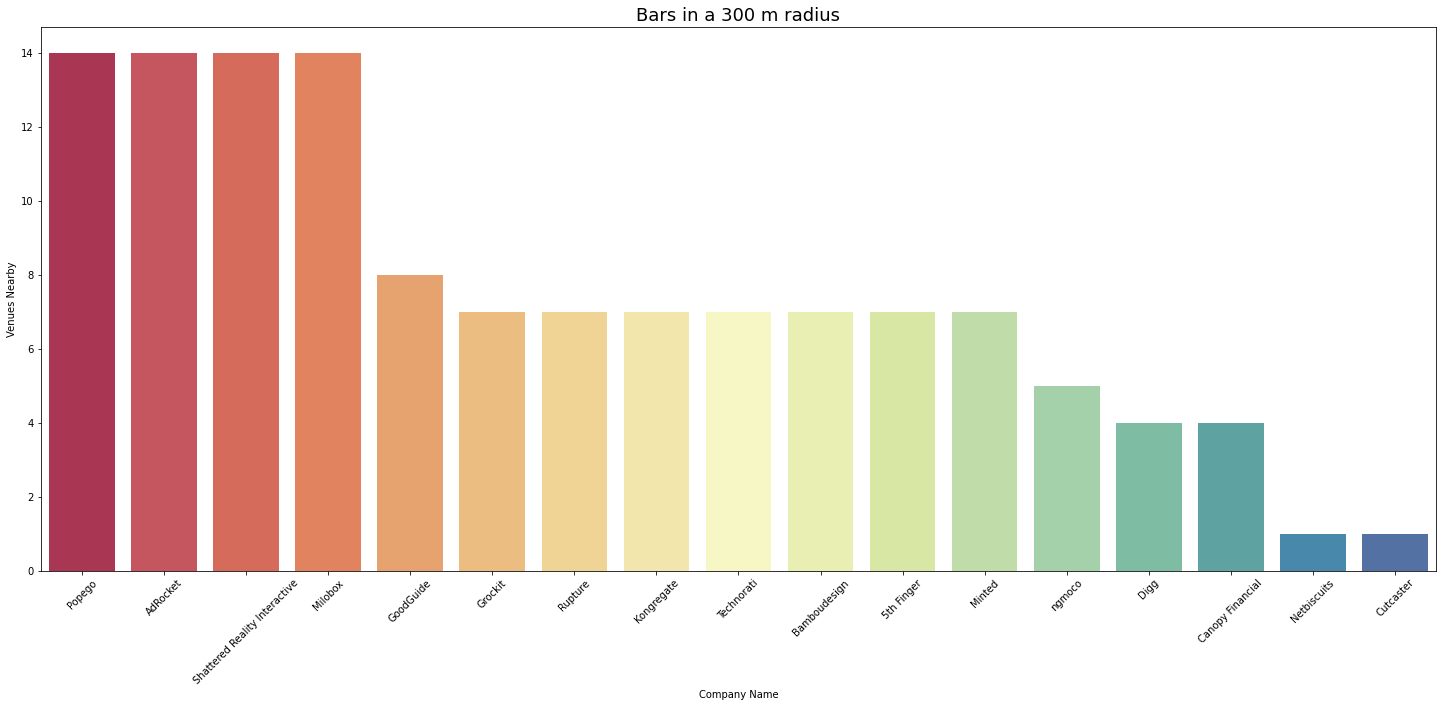

In [100]:
sns.barplot(x=df_sf_bars["Company Name"].value_counts().index, y=df_sf_bars["Company Name"].value_counts(), palette="Spectral")
plt.title("Bars in a 300 m radius", size=18)
plt.xlabel('Company Name')
plt.ylabel('Venues Nearby')
plt.rcParams["figure.figsize"] = (25,10)
plt.xticks(rotation=45)
plt.show()

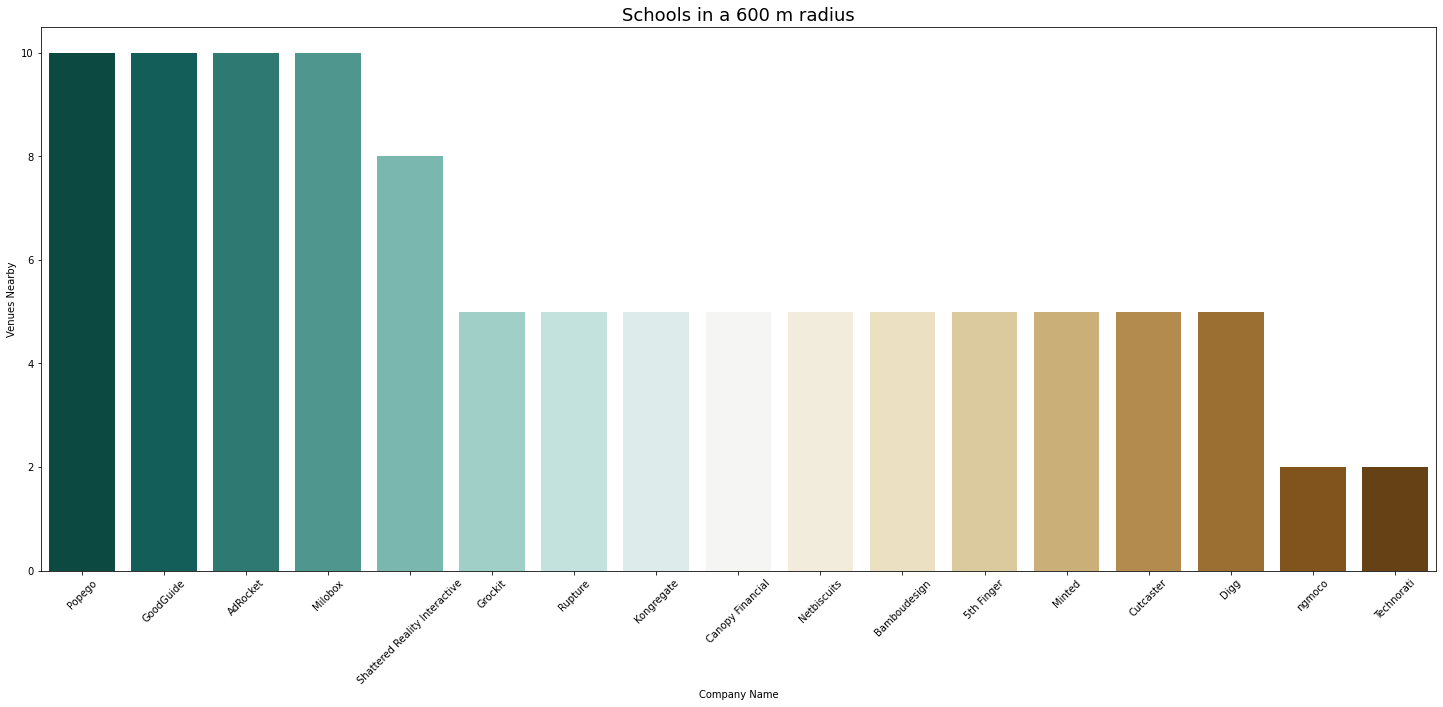

In [113]:
sns.barplot(x=df_sf_schools["Company Name"].value_counts().index, y=df_sf_schools["Company Name"].value_counts(), palette="BrBG_r")
plt.title("Schools in a 600 m radius", size=18)
plt.xlabel('Company Name')
plt.ylabel('Venues Nearby')
plt.rcParams["figure.figsize"] = (25,10)
plt.xticks(rotation=45)
plt.show()

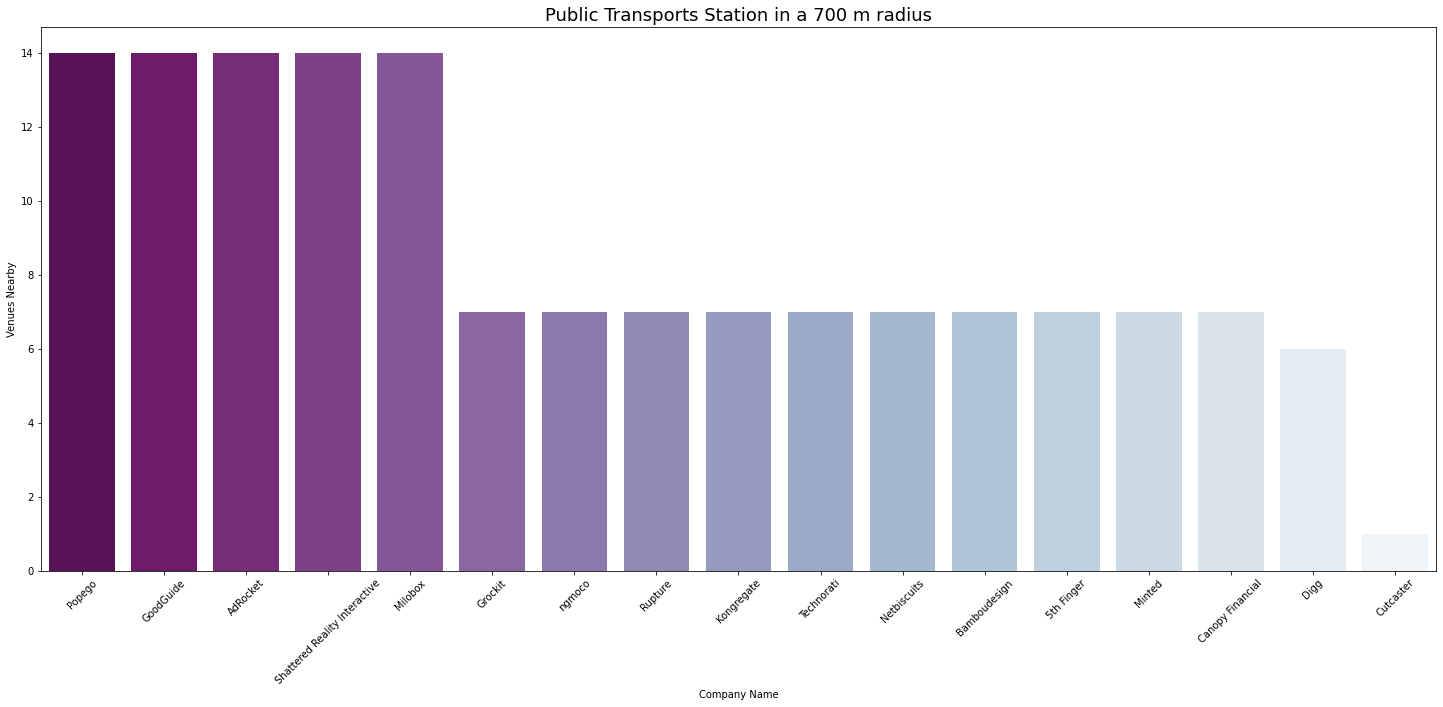

In [104]:
sns.barplot(x=df_sf_stations["Company Name"].value_counts().index, y=df_sf_stations["Company Name"].value_counts(), palette="BuPu_r")
plt.title("Public Transports Station in a 700 m radius", size=18)
plt.xlabel('Company Name')
plt.ylabel('Venues Nearby')
plt.rcParams["figure.figsize"] = (25,10)
plt.xticks(rotation=45)
plt.show()

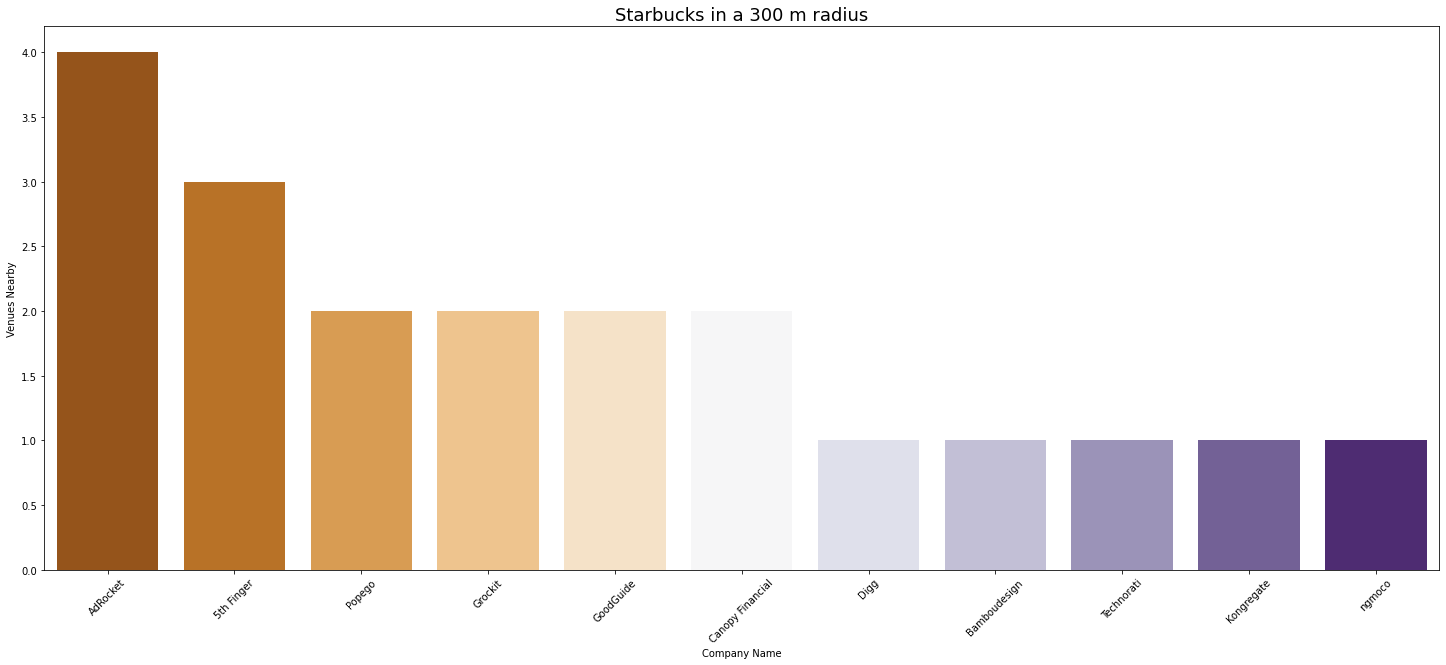

In [112]:
sns.barplot(x=df_sf_starbucks["Company Name"].value_counts().index, y=df_sf_starbucks["Company Name"].value_counts(), palette="PuOr")
plt.title("Starbucks in a 300 m radius", size=18)
plt.xlabel('Company Name')
plt.ylabel('Venues Nearby')
plt.rcParams["figure.figsize"] = (25,10)
plt.xticks(rotation=45)
plt.show()

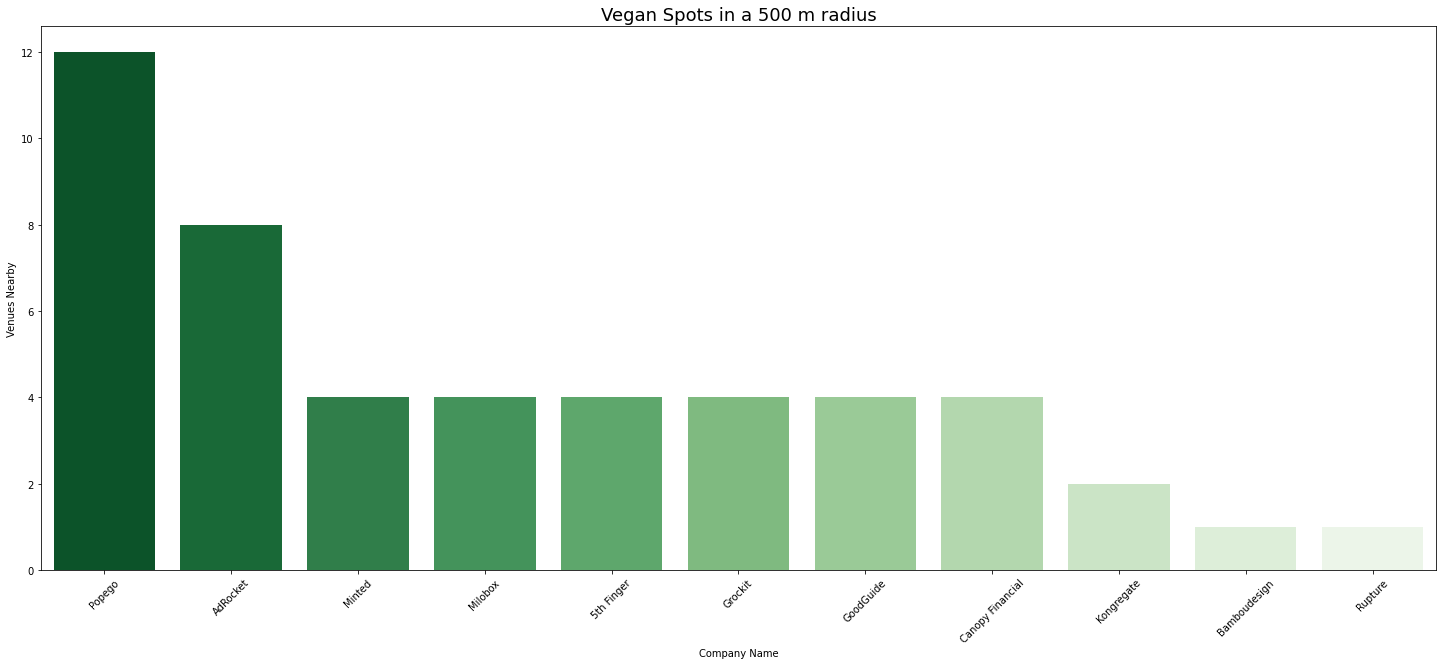

In [107]:
sns.barplot(x=df_sf_vegan["Company Name"].value_counts().index, y=df_sf_vegan["Company Name"].value_counts(), palette="Greens_r")
plt.title("Vegan Spots in a 500 m radius", size=18)
plt.xlabel('Company Name')
plt.ylabel('Venues Nearby')
plt.rcParams["figure.figsize"] = (25,10)
plt.xticks(rotation=45)
plt.show()

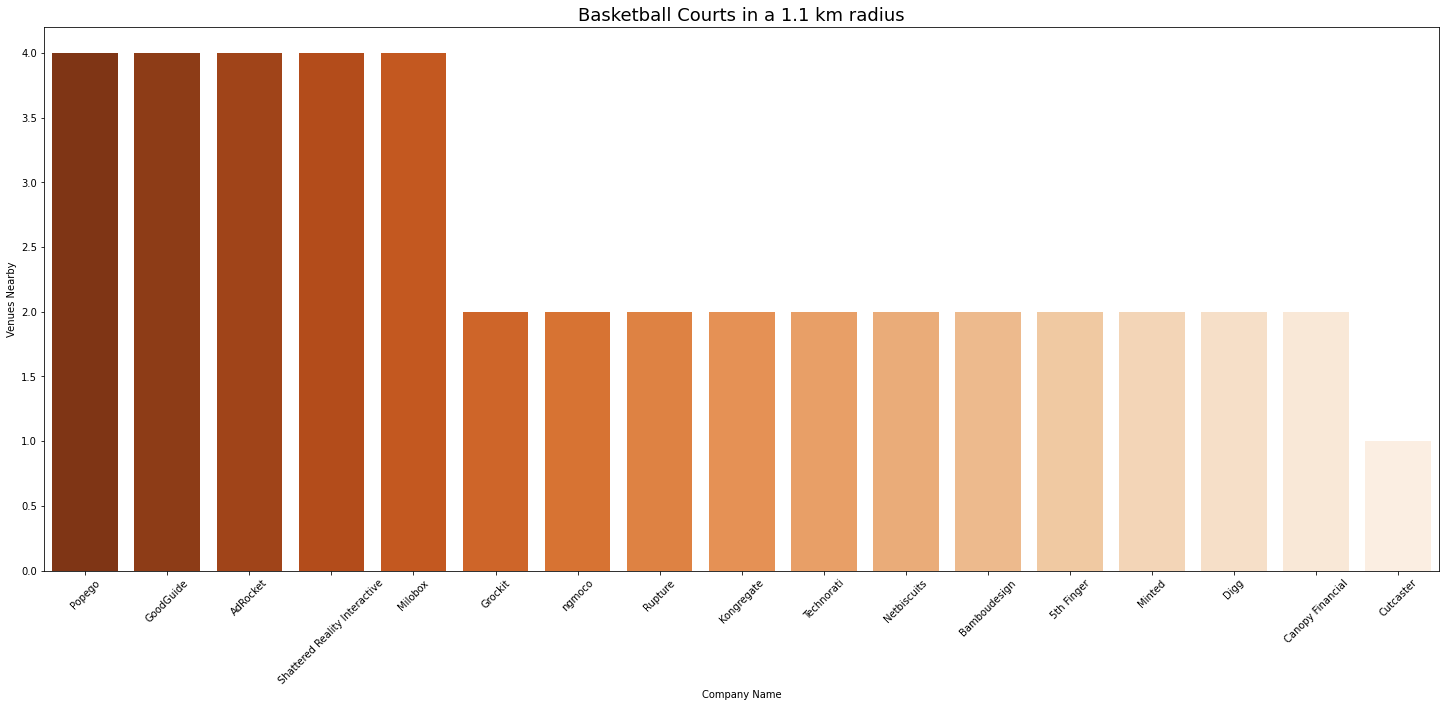

In [109]:
sns.barplot(x=df_sf_basketball["Company Name"].value_counts().index, y=df_sf_basketball["Company Name"].value_counts(), palette="Oranges_r")
plt.title("Basketball Courts in a 1.1 km radius", size=18)
plt.xlabel('Company Name')
plt.ylabel('Venues Nearby')
plt.rcParams["figure.figsize"] = (25,10)
plt.xticks(rotation=45)
plt.show()

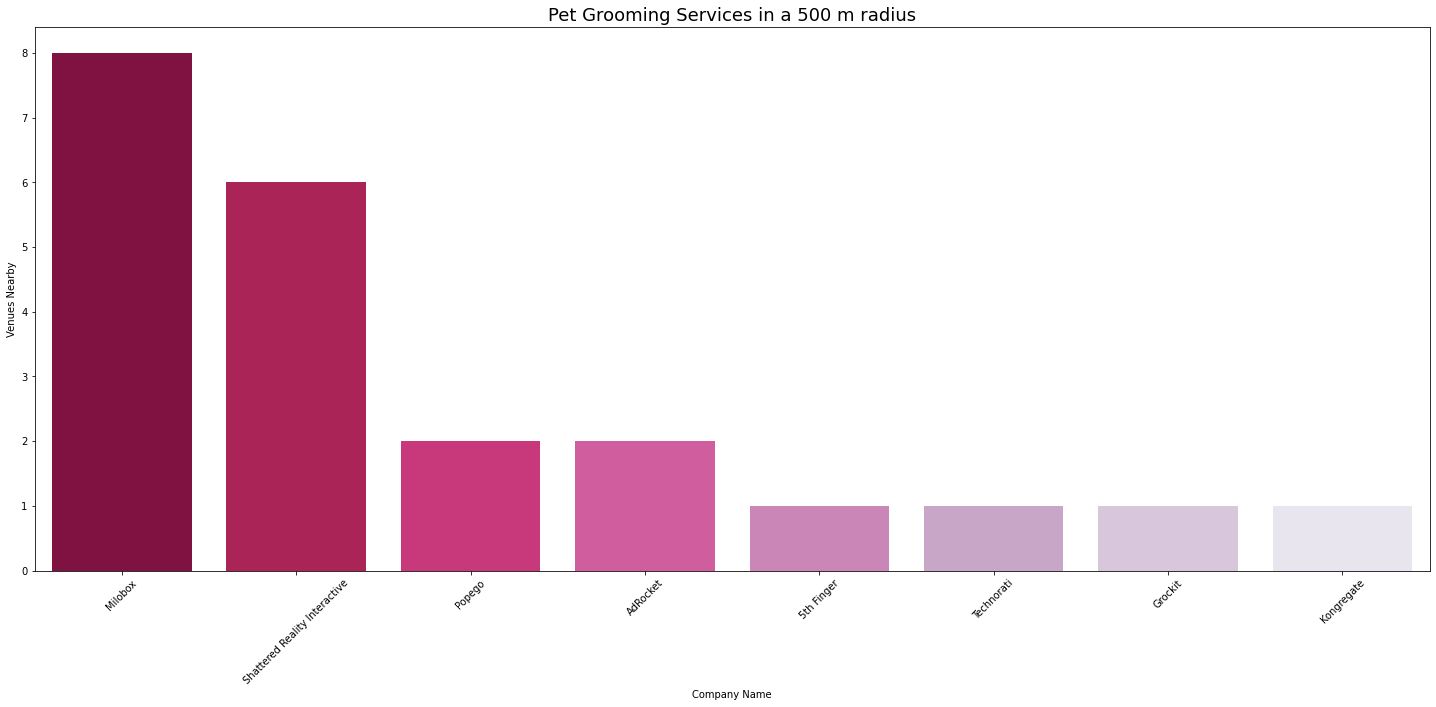

In [111]:
sns.barplot(x=df_sf_petgroom["Company Name"].value_counts().index, y=df_sf_petgroom["Company Name"].value_counts(), palette="PuRd_r")
plt.title("Pet Grooming Services in a 500 m radius", size=18)
plt.xlabel('Company Name')
plt.ylabel('Venues Nearby')
plt.rcParams["figure.figsize"] = (25,10)
plt.xticks(rotation=45)
plt.show()